<a href="https://colab.research.google.com/github/neatnettech/ai_tartu_2024/blob/main/hubmap_segmentation_practice_no_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image segmentation for histopathology

We will use the data from Kaggle competition [HuBMAP - Hacking the Kidney](https://www.kaggle.com/competitions/hubmap-kidney-segmentation)

In [ ]:
!pip install -q kaggle

Download Kaggle API key as shown [here](https://docs.google.com/presentation/d/17OppxF05HE9ABr1cQZQ2RXdF8UaZvuyRoxXTAFrUVLw/edit?usp=sharing). Then upload it to Colab home folder.

In [4]:
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [3]:
!kaggle datasets download -d iafoss/hubmap-256x256

Dataset URL: https://www.kaggle.com/datasets/iafoss/hubmap-256x256
License(s): unknown
100% 1.23G/1.23G [01:08<00:00, 22.4MB/s]
100% 1.23G/1.23G [01:08<00:00, 19.3MB/s]


In [5]:
!mkdir data
!unzip -q hubmap-256x256.zip -d data

## Taking a look at the data

In [6]:
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [7]:
data_path = Path("data")
img_path = data_path / "train"
mask_path = data_path / "masks"

images = sorted(img_path.glob("*.png"))
masks = sorted(mask_path.glob("*.png"))

images[:5] + masks[:5]

[PosixPath('data/train/0486052bb_0079.png'),
 PosixPath('data/train/0486052bb_0080.png'),
 PosixPath('data/train/0486052bb_0081.png'),
 PosixPath('data/train/0486052bb_0082.png'),
 PosixPath('data/train/0486052bb_0083.png'),
 PosixPath('data/masks/0486052bb_0079.png'),
 PosixPath('data/masks/0486052bb_0080.png'),
 PosixPath('data/masks/0486052bb_0081.png'),
 PosixPath('data/masks/0486052bb_0082.png'),
 PosixPath('data/masks/0486052bb_0083.png')]

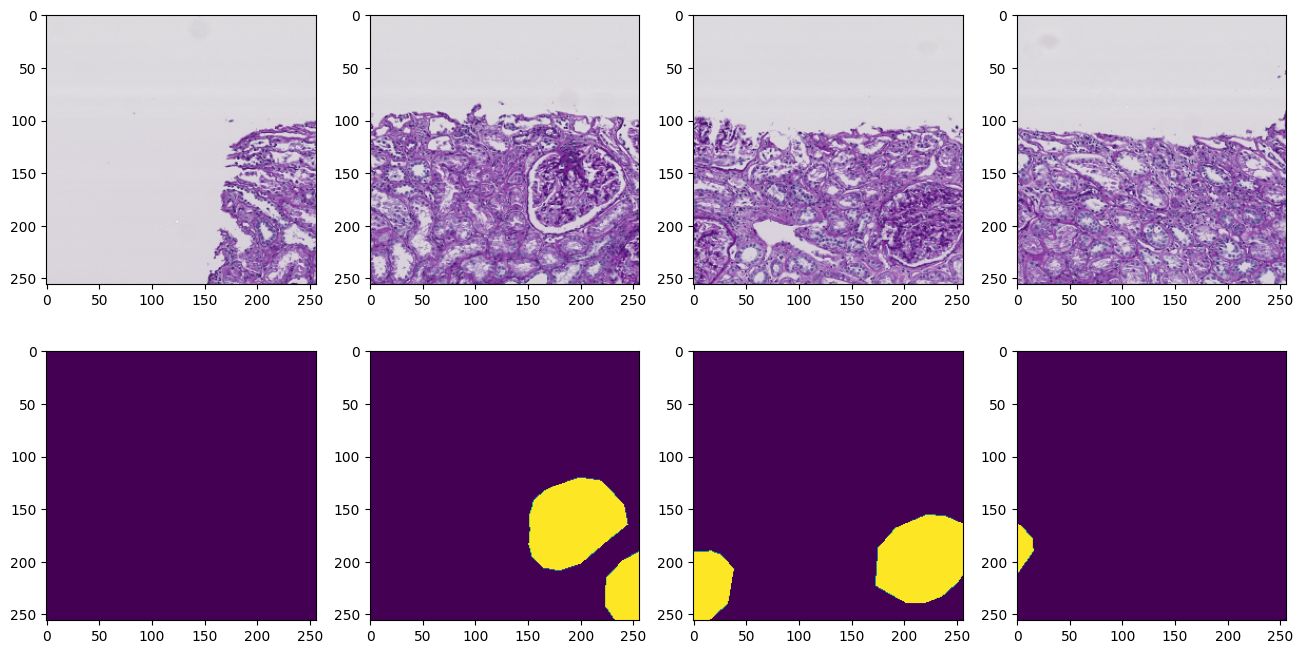

In [8]:
n_images = 4
img_size = 4
fig, axes = plt.subplots(ncols=n_images, nrows=2, figsize=(img_size * n_images, img_size * 2))
for ax, im, ms in zip(axes.T, images, masks):
    image = plt.imread(im)
    mask = plt.imread(ms)
    ax[0].imshow(image)
    ax[1].imshow(mask)
plt.show()

## Dataset

In [9]:
import numpy as np
from PIL import Image

import torch
from torch import Tensor as T
from torch.utils.data import DataLoader, Dataset

from torchvision.transforms import v2
from torchvision import tv_tensors

from sklearn.model_selection import train_test_split

In [10]:
class HubmapDataset(Dataset):
    def __init__(
        self,
        images: list[Path],
        masks: list[Path],
        transforms: list[v2.Transform],
        ):

        super().__init__()
        self.images = images
        self.masks = masks
        self.transforms = v2.Compose(transforms)

    def __getitem__(self, i: int) -> dict[str, T]:
        # Read one image by an index

        image = Image.open(self.images[i]).convert("RGB")
        mask = Image.open(self.masks[i])

        image = tv_tensors.Image(image)
        mask = tv_tensors.Mask(mask, dtype=torch.float32)

        sample = {
            "image": image,
            "mask": mask,
        }

        sample = self.transforms(sample)
        return sample

    def __len__(self):
        return len(self.images)

Check PyTorch documentation and fill in the list of train transforms.

In [24]:
transforms_val = [
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]

transforms_train = [
    # https://pytorch.org/vision/stable/transforms.html
    ### BEGIN SOLUTION
    v2.RandomResizedCrop(224),          # crops the image to a specified size and aspect ratio
    v2.RandomHorizontalFlip(p=0.5),          # flips the image horizontally
    v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),  # changes brightness, contrast, etc.
    ### END SOLUTION
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]

Split images into train and validation set

In [25]:
images_train, images_val, masks_train, masks_val = train_test_split(images, masks, test_size=0.2, random_state=11)
len(images_train), len(images_val)

(7664, 1916)

In [26]:
ds_train = HubmapDataset(images_train, masks_train, transforms_train)
ds_val = HubmapDataset(images_val, masks_val, transforms_val)

In [27]:
def denormalize(tensor: T,
                mean: tuple[float, float, float] = (0.485, 0.456, 0.406),
                std: tuple[float, float, float] = (0.229, 0.224, 0.225)):
    return (np.moveaxis(tensor.numpy(), 0, -1) * std + mean).clip(0, 255)

Run cells below multiple times, notice the difference?

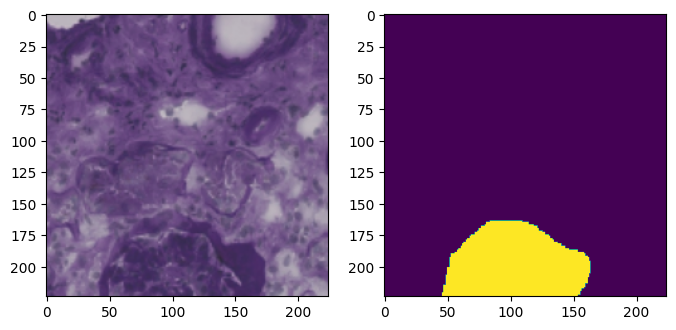

In [28]:
sample = ds_train[4000]

fig, ax = plt.subplots(ncols=2, figsize=(img_size * 2, img_size))
ax[0].imshow(denormalize(sample["image"]))
ax[1].imshow(sample["mask"][0])
plt.show()

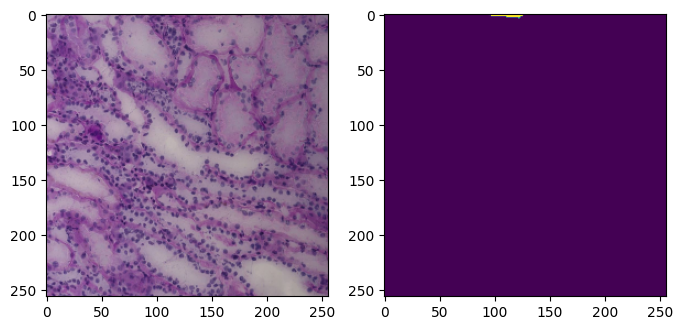

In [29]:
sample = ds_val[1000]

fig, ax = plt.subplots(ncols=2, figsize=(img_size * 2, img_size))
ax[0].imshow(denormalize(sample["image"]))
ax[1].imshow(sample["mask"][0])
plt.show()

## Data loader

Handles multiprocess data loading and batching. Check the documentation for details: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [17]:
batch_size = 32
num_workers = 0

loader_train = DataLoader(ds_train,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_workers)

loader_val = DataLoader(ds_val,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=num_workers)

len(loader_train), len(loader_val)

(240, 60)

## Segmentation model

In [ ]:
!pip install -q segmentation-models-pytorch

In [ ]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

## Loss function

We will use a combination of cross-entropy and Dice:

$$\text{Dice} = \frac{\text{2 * TP}}{\text{2 * TP} + \text{FP} + \text{FN}}$$

In [ ]:
from functools import partial
from typing import Any, Callable
from torch import nn

In [ ]:
def dice(
    outputs: T,
    targets: T,
    eps: float = 1e-7,
    threshold: float = None,
    sigmoid: bool = True,
) -> T:
    if sigmoid:
        outputs = nn.functional.sigmoid(outputs)

    if threshold is not None:
        outputs = (outputs > threshold).float()

    intersection = torch.sum(outputs * targets)
    union = torch.sum(outputs) + torch.sum(targets)
    score = (2 * intersection + eps * (union == 0)) / (union + eps)

    return score


def dice_loss(outputs: T, targets: T, **kwargs) -> T:
    return 1 - dice(outputs, targets, **kwargs)

In [ ]:
class Loss(nn.Module):
    def __init__(self, loss_fn: Callable, element_wise: bool = False, **kwargs: Any):
        super().__init__()
        self.element_wise = element_wise
        self.loss_fn = partial(loss_fn, **kwargs)

    def forward(self, logits: T, targets: T) -> T:
        """
        Calculates loss between ``logits`` and ``target`` tensors.
        :param logits: model logits (B, C, H, W)
        :param targets: ground truth labels (B, C, H, W)
        :return: computed loss
        """
        assert logits.shape == targets.shape
        # Iterate over batch dimension if element_wise
        if not self.element_wise:
            logits, targets = [logits], [targets]
        loss = torch.stack([self.loss_fn(o, t) for o, t in zip(logits, targets)])
        return loss.mean()


class DiceLoss(Loss):
    def __init__(
        self,
        eps: float = 1e-7,
        threshold: float = None,
        sigmoid: bool = True,
        element_wise: bool = False,
    ):
        """
        Dice loss

        :param eps: smoothing parameter, default 1e-7
        :param threshold: threshold logits if necessary
        :param activation: activation function
        :param element_wise: calculate by element in the batch, then average
        """
        super().__init__(
            loss_fn=dice_loss,
            element_wise=element_wise,
            threshold=threshold,
            sigmoid=sigmoid,
            eps=eps,
        )

## Training loop

Your task is to complete missing parts in the code below as the comments describe. If you struggle, take a look at the official [PyTorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) or ask straight away!

In [ ]:
from torch import nn
from tqdm import tqdm

In [ ]:
class Trainer:
    def __init__(self, model: nn.Module, device: str = "cuda"):
        self.device = device
        self.criterion = {
            "bce": nn.BCEWithLogitsLoss(),
            "dice": DiceLoss(),
        }
        self.model = model
        # TODO: you can try to parametrize optimizer later in your experiments
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.scheduler = None

    def train(self,
              epochs: int,
              train_loader: DataLoader,
              test_loader: DataLoader) -> tuple[list[float], list[float]]:
        """
        Train loop

        params:
            train_loader: DataLoader, training loader
            test_loader: DataLoader, test loader
        returns: None
        """
        self.model.to(self.device)

        # Logging
        train_loss = []
        test_acc = []

        # Set up scheduler
        # TODO: you can try to parametrize scheduler later in your experiments
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, T_max=epochs * len(train_loader), eta_min=1e-7)


        for i in range(epochs):
            try:
                loss = self.train_loop(train_loader, i)
                acc = self.test_loop(test_loader)
                train_loss.append(loss)
                test_acc.append(acc)

                # Save model checkpoint, use tutorial for the reference:
                # https://pytorch.org/tutorials/beginner/saving_loading_models.html
                ### BEGIN SOLUTION
                ### END SOLUTION
            except KeyboardInterrupt:
                # so you can interrupt the kernel and stop the training
                print(f"Training interrupted at epoch {i}")
                break
        return train_loss, test_acc


    def train_loop(self, loader: DataLoader, epoch: int = 0) -> float:
        """
        Train loop

        params:
            loader: DataLoader, training loader
            epoch: int, epoch id for logging
        returns: float, average loss
        """
        # Set training mode for `self.model`
        # https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch
        ### BEGIN SOLUTION
        ### END SOLUTION

        # Set up logging
        iterator = tqdm(loader, desc=f"ep.{epoch:04d}", position=0)
        running_loss = 0.0

        for i, batch in enumerate(iterator):
            inputs, labels = batch["image"], batch["mask"]
            # Move both inputs and labels to `self.device`
            # https://stackoverflow.com/questions/63061779/pytorch-when-do-i-need-to-use-todevice-on-a-model-or-tensor
            ### BEGIN SOLUTION
            ### END SOLUTION

            # Zero the parameter gradients using the respective method of `self.optimizer`
            # https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html
            ### BEGIN SOLUTION
            ### END SOLUTION

            # Do forward pass of `self.model`
            # https://stackoverflow.com/questions/55338756/why-there-are-different-output-between-model-forwardinput-and-modelinput
            outputs = ...
            ### BEGIN SOLUTION
            ### END SOLUTION

            # Calculate the loss using the outputs of your model
            # Hint: criterion is a dict, take functions by keys.
            loss_bce = ...
            loss_dice = ...
            ### BEGIN SOLUTION
            ### END SOLUTION
            # TODO: experiment with loss weights
            loss = loss_bce + loss_dice

            # Do backward pass using the respective method of `loss`
            # https://discuss.pytorch.org/t/what-does-the-backward-function-do/9944
            ### BEGIN SOLUTION
            ### END SOLUTION

            # Do an optimization step using the respective method of `self.optimizer`
            # https://stackoverflow.com/questions/53975717/pytorch-connection-between-loss-backward-and-optimizer-step
            ### BEGIN SOLUTION
            ### END SOLUTION

            # Do a scheduler step using the respective method of `self.scheduler`
            if self.scheduler is not None:
                ### BEGIN SOLUTION
                ### END SOLUTION
                pass


            # Show training statistics
            # NB! Always use loss.item() and not just loss when storing the value!
            # Otherwise you will quickly run out of memory
            running_loss += loss.item()
            iterator.set_postfix({"loss": running_loss / (i + 1),
                                 "lr": f"{self.scheduler.get_last_lr()[0]: .4e}"})

        return running_loss / len(iterator)

    def test_loop(self, loader: DataLoader) -> float:
        """
        Test loop

        params:
            loader: DataLoader, test loader
        returns: float, accuracy
        """
        # Set evaluation mode for `self.model`
        # https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch
        ### BEGIN SOLUTION
        ### END SOLUTION

        # Set up logging
        iterator = tqdm(loader, position=0)
        running_metric = 0

        # We do not need gradients in test phase, so we use `no_grad` scope
        with torch.no_grad():
            for i, batch in enumerate(iterator):
                inputs, labels = batch["image"], batch["mask"]
                # Move both inputs and labels to `self.device`
                ### BEGIN SOLUTION
                ### END SOLUTION

                # Do forward pass of `self.model`
                ### BEGIN SOLUTION
                ### END SOLUTION

                # The class with the highest energy is what we choose as prediction
                metric = dice(outputs, labels)
                running_metric += metric.item()

                # Show current results (accuracy)
                iterator.set_postfix({"dice": running_metric / (i + 1)})

        return running_metric / len(iterator)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using", device)

trainer = Trainer(model, device=device)

In [ ]:
train_loss_baseline, test_dice_baseline = trainer.train(2, loader_train, loader_val)

Now you can download the weights from Files menu on the left.

## Deployment

1. [Sign in](https://share.streamlit.io/signup) to Streamlit Community Cloud
2. Follow [instructions](https://docs.streamlit.io/streamlit-community-cloud/get-started/quickstart) to setup Github Workspaces

Your code is running in a container: you need to add required packages and rebuild it
```
torch
torchvision
segmentation-models-pytorch
```


Create `Segmentation_Demo.py` file in `pages`:

```
import streamlit as st
from streamlit.hello.utils import show_code
import numpy as np
import torch
from torchvision.transforms import v2
from torchvision import tv_tensors
from PIL import Image

import segmentation_models_pytorch as smp


def segmentation_demo():
    model_weights = st.file_uploader("Choose a model file")
    image = st.file_uploader("Choose an image")

    if image is not None:
        image = Image.open(image).convert("RGB")
        st.image(image, "Uploaded image")

    if model_weights is not None:
        # Define model as above since you saved only the weights
        model = ...
        ### BEGIN SOLUTION
        
        ### END SOLUTION

        # Load model (be careful with `map_location`, read documentation above)
        ### BEGIN SOLUTION
        
        ### END SOLUTION

        # Switch to eval mode (as in test loop)
        ### BEGIN SOLUTION
        
        ### END SOLUTION

        # Use the same transforms as above
        transforms = ...
        ### BEGIN SOLUTION
        
        ### END SOLUTION

        if image is not None:
            # Apply transforms (don't forget to wrap image as tv_tensors.Image)
            tensor = ...

            ### BEGIN SOLUTION
            
            ### END SOLUTION

            # Add batch dimension
            tensor = tensor[None, ...]

            # Do the forward pass (don't forget `torch.no_grad()`!)
            ### BEGIN SOLUTION
            
            ### END SOLUTION

            # Show image
            st.image(mask[0, 0], "Predicted mask")

# Setup page
st.set_page_config(page_title="Segmentation Demo", page_icon="🔬")
st.markdown("# Segmentation Demo")
st.sidebar.header("Segmentation Demo")

# Run page
segmentation_demo()

show_code(segmentation_demo)
```